Advanced Lane Finding
===

#### Building an advanced lane lines finding algorithm

In this project, the goal is to write a software pipeline to identify the lane boundaries in a video, and to measure things like how much the lane is curving and where the vehicle is with respect to center. The algorithm will handle complex scenarios like curving lines, shadows and changes in the color of the pavement.

The steps of this project are the following:
* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import pickle

## Calibration the camera with OpenCV
Extract object points and image points for camera calibration

The camera_calibration() function compute the camera calibration matrix and distortion coefficients. We only need to compute these once, and then we'll apply them to undistort each new frame from the pipeline

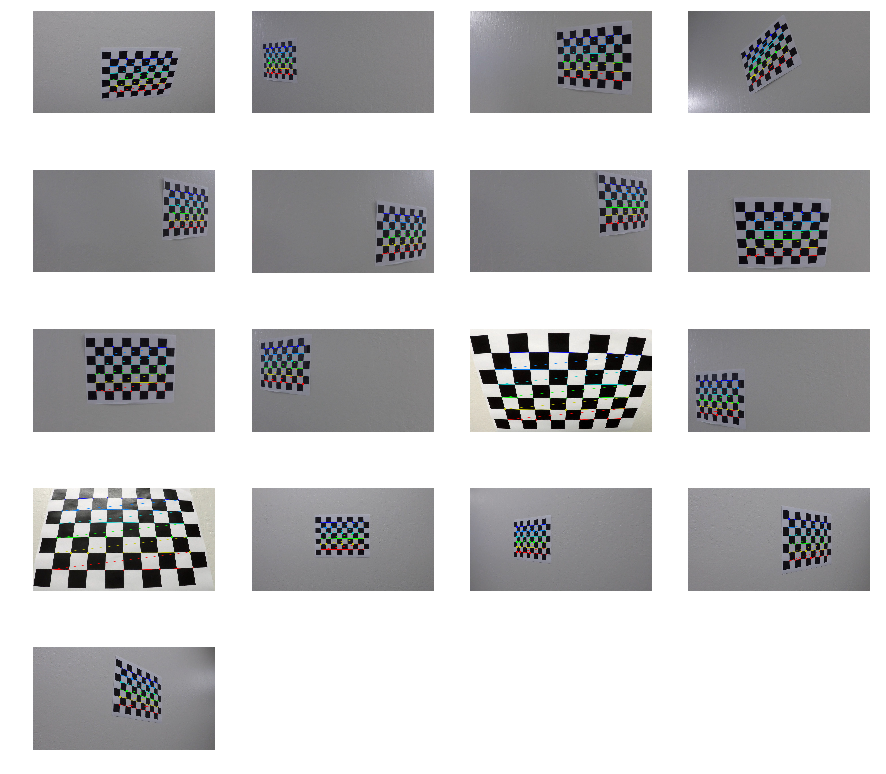

In [4]:
def camera_calibration():
    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3D points in real world space 
    imgpoints = [] # 2D points in image plane
    sample_images=[] # for display in the notebook
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3),np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    # Make a list of calibration images
    images = glob.glob('C:\\data\\camera_cal\\cal*')
    
    for fname in images:
        img = mpimg.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
        
        # If found, add object points, image points
        if ret == True:
            imgpoints.append(corners)
            objpoints.append(objp)
            #draw lines on the cheesboard
            img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
            sample_images.append(img)

    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    #save the calibration data in a pickle file to use later
    camera_cal_val = "camera_calibration.p" 
    output = open(camera_cal_val, 'wb')

    # Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
    dist_pickle = {}
    dist_pickle["mtx"] = mtx
    dist_pickle["dist"] = dist
    pickle.dump(dist_pickle, output)
    output.close()
    
    plt.figure(figsize=(15, 20))
    for i in range(len(sample_images)):
       # Displaying the images 
        plt.subplot(7, 4, i+1)
        plt.imshow(sample_images[i]) 
        plt.axis('off')
    
camera_calibration()


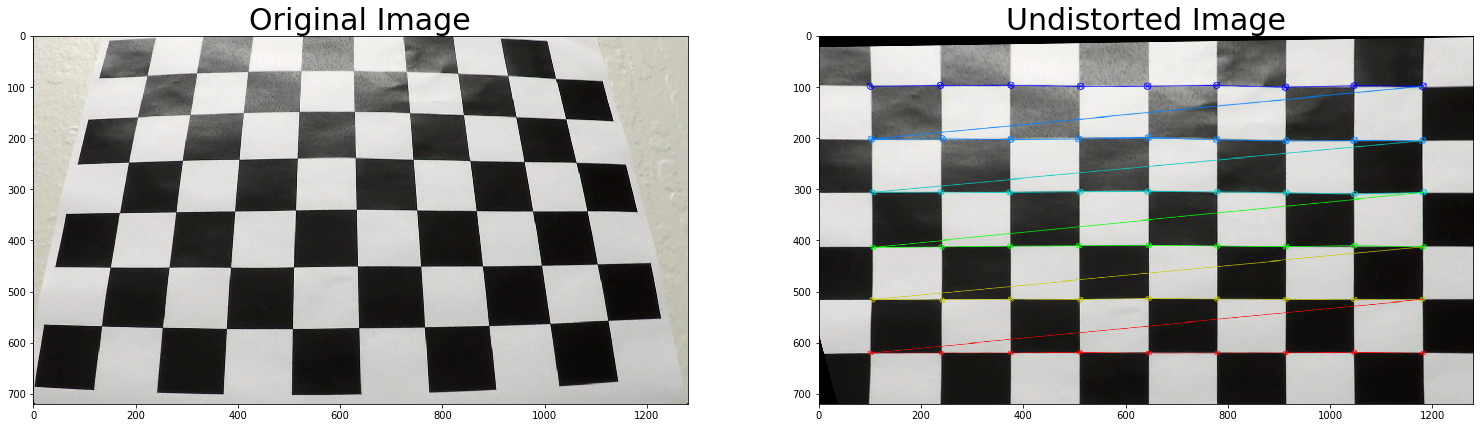

In [93]:
%matplotlib inline

# Return the saved object points and image points 
def get_camera_calibration():
    dist_pickle = pickle.load( open( "camera_calibration.p", "rb" ) )
    mtx = dist_pickle["mtx"]
    dist = dist_pickle["dist"]
    return mtx, dist

# Takes an image, object points, and image points
# performs the camera calibration, image distortion correction and 
# returns the undistorted image
def cal_undistort(img, mtx, dist):
    img_size = (img.shape[1], img.shape[0])
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

# A function that takes an image, number of x and y points, 
# camera matrix and distortion coefficients, and return the undistort image with chessboard corners
def corners_unwarp(img, mtx, dist):
    nx, ny = 9, 6
    # Use the OpenCV undistort() function to remove distortion
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    # Convert undistorted image to grayscale
    gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
    # Search for corners in the grayscaled image
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    if ret == True:
        # If we found corners, draw them
        cv2.drawChessboardCorners(undist, (nx, ny), corners, ret)
        # Choose offset from image corners to plot detected corners
        # This should be chosen to present the result at the proper aspect ratio
        offset = 100 # offset for dst points
        # Grab the image shape
        img_size = (gray.shape[1], gray.shape[0])

        # For source points I'm grabbing the outer four detected corners
        src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
        # For destination points, I'm arbitrarily choosing some points to be
        # a nice fit for displaying our warped result 
        dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                                     [img_size[0]-offset, img_size[1]-offset], 
                                     [offset, img_size[1]-offset]])
        # Given src and dst points, calculate the perspective transform matrix
        M = cv2.getPerspectiveTransform(src, dst)
        # Warp the image using OpenCV warpPerspective()
        warped = cv2.warpPerspective(undist, M, img_size)
    # Return the resulting image and matrix
    return warped

# Read in the test image
img = mpimg.imread('/home/carnd/vehicle_detection/test_images/test.jpg')

mtx, dist = get_camera_calibration()
undistorted = corners_unwarp(img, mtx, dist)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 9))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

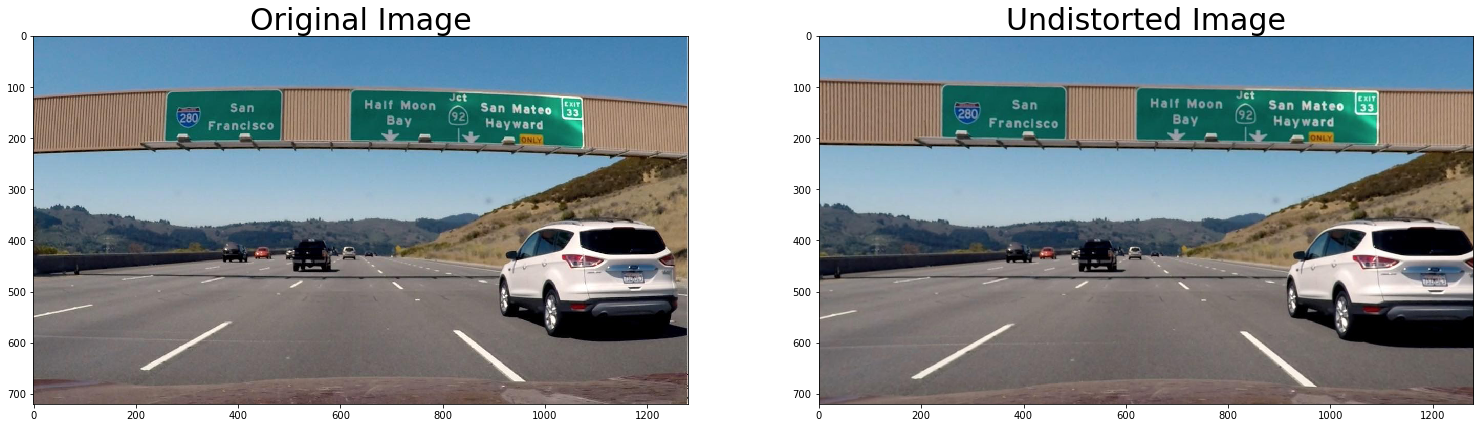

In [6]:
#Here is an example of the distortion correction on an image from the car camera:
%matplotlib inline

img = mpimg.imread('C:\\data\\distortion\\vehicles.png')

mtx, dist = get_camera_calibration()
undistorted = cal_undistort(img, mtx, dist)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 9))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Perspective Transform

Objects appears smaller the farther away they are from a viewpoint, and parallel lines seems to converge to a point. A perspective transform maps the points in a given image to different, desired, image points with a new perspective. We're interesting in the bird’s-eye view transform that let’s us view a lane from above.

I used the cv2.getPerspectiveTransform() and cv2.warpPerspective() functions to transform the apparent Z coordinate of the object points. Warp an image and effectively drag points towards the camera to change the apparent perspective.

I applied a perspective transform that zooms in on the farther object on the road images, and lets us change our perspective to view the same scene from different viewpoints and angles.

The code in the cell below dynamically calculate the source and destination points and apply the cv2 functions on the image. I verified that my perspective transform was working as expected by drawing the src and dst points onto a test image and its warped counterpart, to verify that the lines appear parallel in the warped image, whether they are straight or curved.

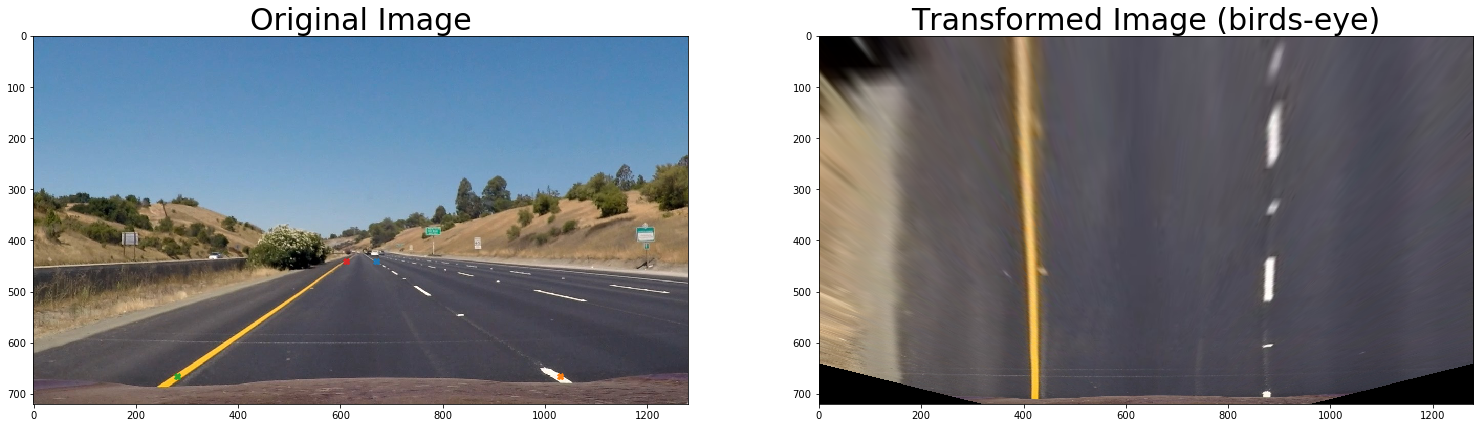

In [3]:
# perspective transform on undistorted images
%matplotlib inline

def perspective_transform(image):
    shape_x = image.shape[0]
    shape_y = image.shape[1]
    
    # dynamically calculate the source and destination points
    src = np.float32([[(.55*shape_y, 0.63*shape_x), (shape_y,shape_x),(0,shape_x),(.45*shape_y, 0.63*shape_x)]])
    dst = np.float32([[0.75*shape_y,0],[0.75*shape_y,shape_x], [0.25*shape_y,shape_x],[0.25*shape_y,0]])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    newwarp = cv2.warpPerspective(image, M, (image.shape[1], image.shape[0]), flags = cv2.INTER_LINEAR) 
    return newwarp, Minv

image = mpimg.imread('C:\\data\\distortion\\test7.jpg')
newwarp, Minv = perspective_transform(image)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 9))
ax1.imshow(image)
ax1.plot(670,440,'X')
ax1.plot(1030,666,'X')
ax1.plot(280,666,'X')
ax1.plot(610,440,'X')
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(newwarp)
ax2.set_title('Transformed Image (bird''s-eye)', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Thresholded binary image

To create a thresholded binary image we need to use various aspects of the gradient measurements like thresholds of the x and y gradients, the overall gradient magnitude, and the gradient direction to focus on pixels that are likely to be part of the lane lines. I used a combination of the following techniques:

1. Sobel - Using the Sobel operation to identify pixels where the gradient of an image falls within a specified threshold range.

2. Magnitude of the Gradient - The absolute value of the gradient is the square root of the squares of the individual x and y gradients.

3. Direction of the Gradient - The direction of the gradient is the inverse tangent (arctangent) of the y gradient divided by the x gradient (The direction of the gradient is much noisier than the gradient magnitude).

4. Saturation (S channel) - a measurement of colorfulness. As colors get lighter and closer to white, they have a lower saturation value, whereas colors that are the most intense, like a bright primary color (bright yellow), have a high saturation value. the S channel is doing a fairly robust job by picking up the lines under very different color and contrast conditions (while other selections sometimes look messy).

5. Value (R channel) - represent a way to measure the relative lightness or darkness of a color. The R channel performing well on the white lines.

6. Histogram equalization - improve the contrast of our images, in order to improve the white lines detection.


In [5]:
# Identify pixels where the gradient of an image falls within a specified threshold range.
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobel = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    if orient == 'y':
        sobel = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the derivative or gradient
    abs_sobelx = np.absolute(sobel)
    # Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    # Create a mask of 1's where the scaled gradient magnitude is bwtween the thresholds 
    sobel_binary = np.zeros_like(scaled_sobel)
    sobel_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return sobel_binary
 
# Calculate gradient magnitude
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Take the gradient in x and y separately
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    return binary_output

# Calculate gradient direction
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Take the gradient in x and y separately
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the direction of the gradient using the absolute value of the x and y gradients
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    return binary_output.astype(np.uint8)


In [6]:
# This cell is part of the pipeline and will handle the lane line detection using the 
# combination of various aspects described above.

def thresholding_main(image):
    sobel_x_thresh=(211,255)
    sobel_y_thresh=(0,25)
    magnitude_thresh=(150,255)
    dir_thresh=(0.7,1.3)
    s_thres=(113,255)
    v_thres=(235,255)
    sobel_kernel = 15
    adp_thresh = 250
    y_size = image.shape[0]
    x_size = image.shape[1]
    inner_trapeze = np.array([[(.5*x_size, 0.68*y_size), (x_size*0.8,y_size), (x_size*0.25,y_size),(.5*x_size, 0.68*y_size)]], dtype=np.int32)
    mask_trapeze = np.array([[(.6*x_size, 0.55*y_size), (x_size*0.95,y_size), (x_size*0.15,y_size),(.44*x_size, 0.55*y_size)]], dtype=np.int32)
    
    # Convert to HLS color space and set saturation channel
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS).astype(np.float)
    s_channel = hls[:,:,2].astype(np.uint8)
    
    # Convert to HSV color space and set value channel
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV).astype(np.float)
    v_channel = hls[:,:,2].astype(np.uint8)
    
    # Threshold gradient
    gradx = abs_sobel_thresh(v_channel, orient='x', sobel_kernel=sobel_kernel, thresh=sobel_x_thresh)
    grady = abs_sobel_thresh(v_channel, orient='y', sobel_kernel=sobel_kernel, thresh=sobel_y_thresh)
    mag_binary = mag_thresh(v_channel, sobel_kernel=sobel_kernel, mag_thresh=magnitude_thresh)
    dir_binary = dir_threshold(v_channel, sobel_kernel=sobel_kernel, thresh=dir_thresh)
    combined_grad = np.zeros_like(gradx)
    combined_grad[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    
    # Threshold color channel for yellow lanes
    s_binary = np.zeros_like(s_channel).astype(np.uint8)
    s_binary[(s_channel > s_thres[0]) & (s_channel <= s_thres[1])] = 1
    v_binary = np.zeros_like(v_channel).astype(np.uint8)
    v_binary[(v_channel > v_thres[0]) & (v_channel <= v_thres[1])] = 1
    combined_yellow = ((s_binary == 1) | (v_binary == 1)).astype(np.uint8)
    
    # Threshold color channel for white lanes
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY).astype(np.uint8)
    img_hist = cv2.equalizeHist(gray)
    ret, thrs = cv2.threshold(img_hist, thresh=adp_thresh, maxval=255, type=cv2.THRESH_BINARY)
    adp = thrs/255
    
    color_binary = np.zeros_like(gradx)
    color_binary[(combined_grad == 1) | (combined_yellow == 1) | (adp == 1)] = 1
    color_binary = np.dstack(( color_binary, color_binary, color_binary)).astype(np.float32)
    
    # masking - region of interest
    color_binary = region_of_interest(color_binary.astype(np.uint8), mask_trapeze, None)

    return color_binary.astype(np.float32), combined_grad, combined_yellow

def thresholding(img):
    l_thres=(222,255)
    b_thres=(191,255)
    
    # L channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    hls_l = hls[:,:,1]
    hls_l = hls_l*(255/np.max(hls_l))
    binary_l = np.zeros_like(hls_l)
    binary_l[(hls_l > l_thres[0]) & (hls_l <= l_thres[1])] = 1
    
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
    lab_b = lab[:,:,2]
    if np.max(lab_b) > 175: # For the yellow line 
        lab_b = lab_b*(255/np.max(lab_b))
    binary_b = np.zeros_like(lab_b)
    binary_b[((lab_b > b_thres[0]) & (lab_b <= b_thres[1]))] = 1

    combined = np.zeros_like(img)
    combined[(binary_l == 1) | (binary_b == 1)] = 1
    return combined

In [17]:
def region_of_interest(image, mask_trapeze, inner_trapeze):
    
    #defining a blank mask to start with
    mask = np.zeros_like(image)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(image.shape) > 2:
        channel_count = image.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, mask_trapeze, ignore_mask_color)

    # adding inner masking to drop the noise from the middle if the road 
    if (inner_trapeze is not None):
        cv2.fillPoly(image, inner_trapeze, 0)

    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(image, mask)
    return masked_image

The cell below is for notebook presentation only, and designed to enable visualization of the various techniques used to detect the lane lines.

The output result will be printed below

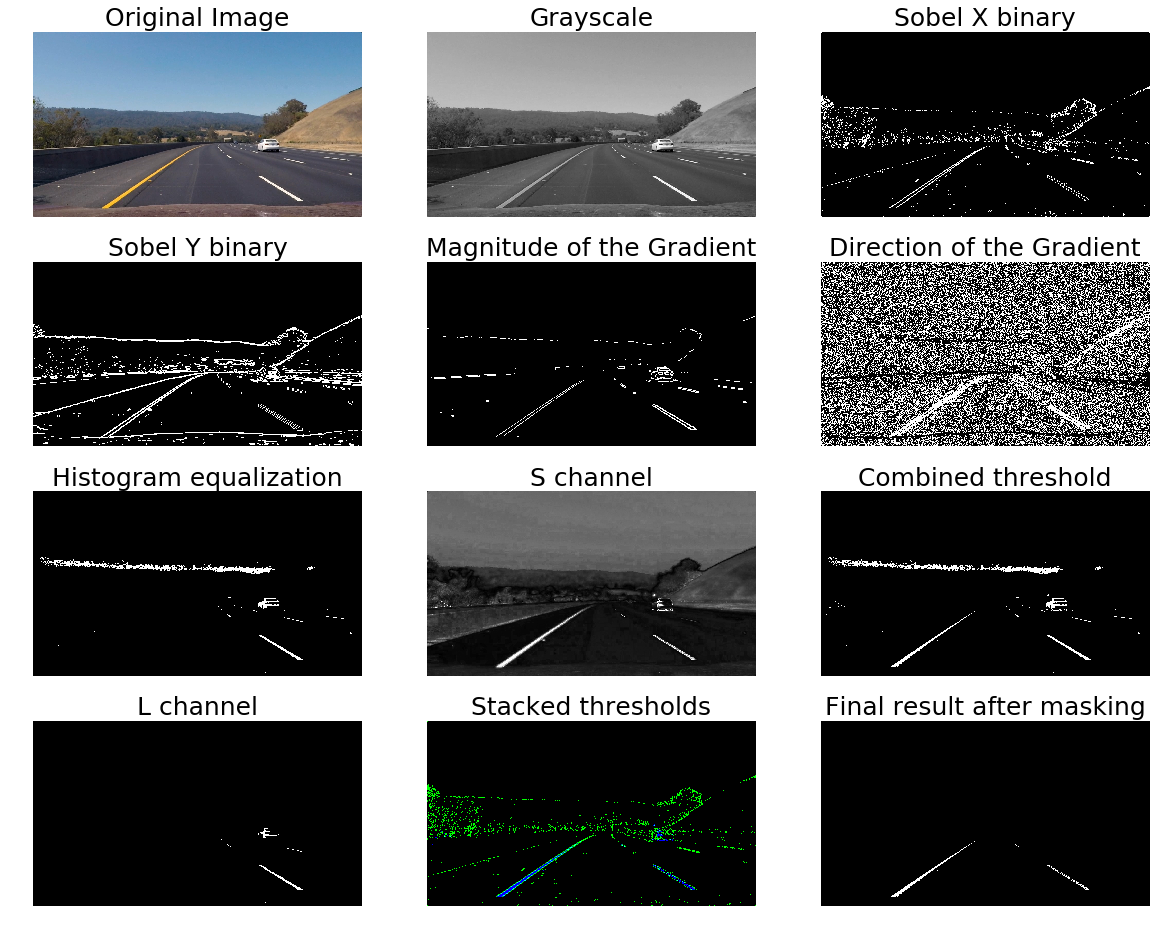

In [30]:
%matplotlib inline

def stacked_thresholds(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    s_channel = hsv[:,:,2]
    # Grayscale image
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    return color_binary

sample_images = []
sample_images_title = []

image = mpimg.imread('C:\\data\\distortion\\test3.jpg')
sample_images.append(image)
sample_images_title.append('Original Image')

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
sample_images.append(gray)
sample_images_title.append('Grayscale')

sobel_x = abs_sobel_thresh(gray, orient='x', sobel_kernel=5, thresh=(20,100))
sample_images.append(sobel_x)
sample_images_title.append('Sobel X binary')

sobel_y = abs_sobel_thresh(gray, orient='y', sobel_kernel=11, thresh=(20,100))
sample_images.append(sobel_y)
sample_images_title.append('Sobel Y binary')

magnitude = mag_thresh(gray, sobel_kernel=13, mag_thresh=(80,240))
sample_images.append(magnitude)
sample_images_title.append('Magnitude of the Gradient')

direction = dir_threshold(gray, sobel_kernel=11, thresh=(0.7, 1.3))
sample_images.append(direction)
sample_images_title.append('Direction of the Gradient')

img_hist = cv2.equalizeHist(gray)
ret, thrs = cv2.threshold(img_hist, thresh=250, maxval=255, type=cv2.THRESH_BINARY)
sample_images.append(thrs/255)
sample_images_title.append('Histogram equalization')

# Convert to HLS color space and separate the S channel
# Note: img is the undistorted image
hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
s_channel = hls[:,:,2]
sample_images.append(s_channel)
sample_images_title.append('S channel')

# Threshold x gradient
thresh_min = 20
thresh_max = 100
sxbinary = np.zeros_like(sobel_x)
sxbinary[(sobel_x >= thresh_min) & (sobel_x <= thresh_max)] = 1

# Threshold color channel
s_thresh_min = 170
s_thresh_max = 255
s_binary = np.zeros_like(s_channel)
s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

# Combine the two binary thresholds
combined_binary = np.zeros_like(sxbinary)
combined_binary[(s_binary == 1) | (thrs/255 == 1) |(sxbinary == 1)] = 1
sample_images.append(combined_binary)
sample_images_title.append('Combined threshold')

# L channel
hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
hls_l = hls[:,:,1]
hls_l = hls_l*(255/np.max(hls_l))
binary_l = np.zeros_like(hls_l)
binary_l[(hls_l > 230) & (hls_l <= 255)] = 1
sample_images.append(binary_l)
sample_images_title.append('L channel')

# Stack each channel to view their individual contributions in green and blue respectively
# This returns a stack of the two binary images, whose components you can see as different colors
sample_images.append(stacked_thresholds(image))
sample_images_title.append('Stacked thresholds')

y_size = image.shape[0]
x_size = image.shape[1]
mask_trapeze = np.array([[(.6*x_size, 0.55*y_size), (x_size,y_size), (0,y_size),(.45*x_size, 0.55*y_size)]], dtype=np.int32)
color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)).astype(np.float32)
# Masking - region of interest 
color_binary = region_of_interest(cv2.cvtColor(color_binary, cv2.COLOR_BGR2GRAY) , mask_trapeze, None)
sample_images.append(color_binary)
sample_images_title.append('Final result after masking')

# Displaying the images 
plt.figure(figsize=(20, 50))
for i in range(len(sample_images)):
    plt.subplot(12, 3, i+1)
    plt.imshow(sample_images[i], cmap='gray') 
    plt.title(sample_images_title[i], fontsize=25)
    plt.axis('off')

## Locate the Lane Lines

We now have a thresholded warped image and we're ready to map out the lane lines. We need to decide explicitly which pixels are part of the lines, and also if they belong to the left or right line.

I used a histogram to add up the pixel values along each column in the image. In my thresholded binary image, pixels are either 0 or 1, so I assumed the two most prominent peaks in this histogram will describe the x-position of the base of the lane lines. From that point, I can use a sliding window, placed around the line centers, to find and follow the lines up to the top of the frame.

The locate_lane_lines() method below is handling the lane lines locating step. I used 20 sliding windows on each image frame, with margin of 50 pixels for each window. I also set a minimum of 50 pixels for a group in the window to recenter the next window on the mean position.

In [8]:
%matplotlib inline

def locate_lane_lines(perspective):
    # getting a warped binary image
    y_size = perspective.shape[0]
    x_size = perspective.shape[1]
    perspective_gray = cv2.cvtColor(perspective, cv2.COLOR_RGB2GRAY).astype(np.uint8)
    mask_trapeze = np.array([[(.8*x_size, 0), (.75*x_size,y_size), (x_size*0.32,y_size),(x_size*0.20, 0)]], dtype=np.int32)
    inner_trapeze = np.array([[(.66*x_size, 0.55*y_size), (x_size*0.68,y_size), (x_size*0.38,y_size),(.4*x_size, 0.55*y_size)]], dtype=np.int32)
 
    binary_warped = region_of_interest(perspective_gray.astype(np.uint8), mask_trapeze, inner_trapeze)

    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    #plt.title('histogram of the bottom of the image')
    #plt.figure(figsize=(14, 3))
    #plt.plot(histogram)
    
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # number of sliding windows
    nwindows = 20
    # height of each window
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 65
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image (for notebook visualization only. on runtime we can comment this lines)
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If we found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Mark lane as detected if at least hakf of the windows were found
    left_lane.detected = False if (leftx.size < nwindows/2) else True
    right_lane.detected = False if (rightx.size < nwindows/2) else True

    # If both lanes were detected - fit a polynomial for each line
    if left_lane.detected == True & right_lane.detected == True:

        left_fit = np.polyfit(lefty, leftx, 2)
        left_lane.best_fit = np.vstack([left_lane.best_fit,left_fit])
        left_lane.best_fit[0] = left_fit
        left_lane.best_fit = np.average(left_lane.best_fit[-left_lane.smoothing_frames:], axis = 0)
        
        right_fit = np.polyfit(righty, rightx, 2)
        right_lane.best_fit = np.vstack([right_lane.best_fit,right_fit])
        right_lane.best_fit[0] = right_fit
        right_lane.best_fit = np.average(right_lane.best_fit[-right_lane.smoothing_frames:], axis = 0)
    else: 
        # used the previous fit
        left_fit = left_lane.best_fit
        right_fit = right_lane.best_fit
        
    # Fit a second order polynomial to pixel positions in each lane line
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    lane_best_fit(left_lane, left_fitx, right_fitx, left_fitx, 800)
    lane_best_fit(right_lane, left_fitx, right_fitx, right_fitx, 1200)
    
    # Reset the lane detected for the next frame 
    left_lane.detected == False
    right_lane.detected == False
    
    '''
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    plt.figure(figsize=(15, 8))
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    plt.imshow(out_img)
    '''
    return (out_img, ploty, (left_lane_inds, right_lane_inds), (left_fitx, right_fitx), (leftx, lefty), (rightx, righty))

def lane_best_fit(lane, left_fitx, right_fitx, fitx, shape):
    if lane.is_first_frame == True:
        lane.is_first_frame = False
        lane.bestx = np.vstack([lane.bestx,fitx])
        lane.bestx[0] = fitx
    if ((left_fitx[0] > right_fitx[0]) | (abs(left_fitx[0] - right_fitx[0])<350) | 
        (abs(left_fitx[0] - fitx[0])>700) | (left_fitx[0] > shape )):
        lane.bestx = np.vstack([lane.bestx,lane.bestx])  
    else:
        lane.bestx = np.vstack([lane.bestx,fitx])
    lane.bestx = np.average(lane.bestx[-lane.smoothing_frames:], axis = 0)
    
#locate_lane_lines(perspective)

The output of the locate_lane_lines method above on a test image looks like this:

![]( https://github.com/shmulik-willinger/advanced_lane_finding/blob/master/readme_img/locate_lane_lines.jpg?raw=true)

## Measuring Curvature
So now we have a thresholded image, where we've estimated which pixels belong to the left and right lane lines and we've fit a polynomial to those pixel positions. Now we'll compute the radius of curvature of the fit.

For the images of this project we can assume the following:
1. The lane is about 30 meters long and 3.7 meters wide.
2. The lane width is 12 feet (3.7 meters) according to the U.S. regulations requirment
3. The dashed lane lines are 10 feet (3 meters) long each.
4. The camera is mounted at the center of the car, such that the lane center is the midpoint at the bottom of the image between the two lines

So we need to define conversions in x and y from pixels space to meters and to calculate the radius of curvature after correcting for scale in x and y.

The method measuring_curvature() below is handling this step, and the output of this procedure on a test image looks like this:
![]( https://github.com/shmulik-willinger/advanced_lane_finding/blob/master/readme_img/measuring_curvature.jpg?raw=true)

In [34]:
%matplotlib inline

def generate_polygon(lane, ploty):
    margin = 10
    window1 = np.array([np.transpose(np.vstack([lane-margin, ploty]))])
    window2 = np.array([np.flipud(np.transpose(np.vstack([lane+margin, ploty])))])
    line_pts = np.hstack((window1, window2))   
    return line_pts

def draw_line(out_img, window_img, left_lane, right_lane, color, ploty):
    left_line_pts = generate_polygon(left_lane, ploty)
    right_line_pts = generate_polygon(right_lane, ploty)
    # display the lane into the warped image
    cv2.fillPoly(out_img, np.int_([left_line_pts]), color)
    cv2.fillPoly(out_img, np.int_([right_line_pts]), color)
    result = cv2.addWeighted(out_img, 1, window_img, 1, 0)
    return result
    
def measuring_curvature(out_img, lane_inds, ploty, fitx, left, right):
    window_img = np.zeros_like(out_img)

    left_lane_inds = lane_inds[0]
    right_lane_inds = lane_inds[1]
    left_fitx = fitx[0]
    right_fitx = fitx[1]

    nonzero = out_img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [255, 0, 0]
        
    #draw_line(out_img, window_img, left_lane.bestx, right_lane.bestx, (255, 255, 0), ploty)
    #result = draw_line(out_img, window_img, left_fitx, right_fitx, (255, 255, 0), ploty)
    
    #if the lane was detectded then calculate the new curvature
    if (left[0].size > 2 | right[0].size > 2) :
        y_eval = np.max(ploty)
        # Define conversions in x and y from pixels space to meters
        # meters per pixel in y dimension. The lane line is 10 ft which is 3.048 meters
        ym_per_pix = 3.048/100 
        # meters per pixel in x dimension. The lane width is 12 ft which is 3.7 meters. 
        # The space between the lines is ~450 pixels
        xm_per_pix = 3.7/450 

        # Fit new polynomials to x,y in world space
        left_fit_cr = np.polyfit(left[1]*ym_per_pix, left[0]*xm_per_pix, 2)
        right_fit_cr = np.polyfit(right[1]*ym_per_pix, right[0]*xm_per_pix, 2)
        
        # Calculate the new radii of curvature
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        avg_curvature = (right_curverad + left_curverad)/2.0
        
        # Calculate the offset from lane center
        lane_centre = (left_fitx[-1] + right_fitx[-1])/2.0
        camera_centre = out_img.shape[1]/2.0
        dist_centre_val = (lane_centre - camera_centre)*3.7/700

        left_lane.line_base_pos = np.vstack([left_lane.line_base_pos,dist_centre_val])
        left_lane.line_base_pos[0] = dist_centre_val
        left_lane.line_base_pos = np.average(left_lane.line_base_pos[-left_lane.smoothing_frames:], axis = 0)
        
        left_lane.radius_of_curvature = np.vstack([left_lane.radius_of_curvature,avg_curvature])
        left_lane.radius_of_curvature[0] = avg_curvature
        left_lane.radius_of_curvature = np.average(left_lane.radius_of_curvature[-left_lane.smoothing_frames:], axis = 0)
        if (left_lane.radius_of_curvature > 1000):
            left_lane.radius_of_curvature = left_lane.radius_of_curvature % 1000
    '''
    # Plot up the data
    mark_size = 3
    plt.figure(figsize=(15, 8))
    plt.plot(left[0], ploty, 'o', color='red', markersize=mark_size)
    plt.plot(right[0], ploty, 'o', color='blue', markersize=mark_size)
    plt.xlim(0, 1280)
    plt.ylim(0, 720)
    plt.plot(left_fitx, ploty, color='green', linewidth=3)
    plt.plot(right_fitx, ploty, color='green', linewidth=3)
    plt.gca().invert_yaxis() # to visualize as we do the images
    '''
    return out_img, ploty


## Tracking
We need to track things like where our last several detections of the lane lines were and what the curvature was, so we can properly treat new detections.
The Line() class below will keep track of all the interesting parameters we measure from frame to frame.

In [76]:
global left_lane 
global right_lane

# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # is it the first frame 
        self.is_first_frame = True
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = np.zeros(720)
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = np.zeros(3)  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = np.zeros(1)
        #distance in meters of vehicle center from the line
        self.line_base_pos = np.zeros(1)
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        #Smoothing last n frames 
        self.smoothing_frames = 10
        
left_lane = Line()
right_lane = Line()
font = cv2.FONT_HERSHEY_SIMPLEX

## Drawing the lane

After we found the lines and computed the radius of curvature, we can draw the lane into the original frame.

First, we will draw the lane. I used Green color for the safety region and Yellow for the rest of the lane. Next, we will use the inverse perspective matrix to warp the lane back to original image space. The last part will be to combine the painted lane with the original image frame.
Here is an example of the output on a test image:

![]( https://github.com/shmulik-willinger/advanced_lane_finding/blob/master/readme_img/lane_finding.jpg?raw=true)


In [23]:
def draw_lane(warped, ploty, Minv):
    # Create an image to draw the lines on
    color_warp = np.zeros_like(warped).astype(np.uint8)

    # Recast the x and y points into usable format for cv2.fillPoly()
    # Draw the lane in yellow
    pts_left = np.array([np.transpose(np.vstack([left_lane.bestx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_lane.bestx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    cv2.fillPoly(color_warp, np.int_([pts]), (255, 255, 0))
    
    # Draw the safety region in green
    
    pts_left = np.array([np.transpose(np.vstack([left_lane.bestx[450:], ploty[450:]]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_lane.bestx[450:], ploty[450:]])))])
    pts = np.hstack((pts_left, pts_right))
    
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))
    
    # Draw the detected lines in colors
    cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(255,0,0), thickness=14)
    cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(0,0,255), thickness=14)
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (warped.shape[1], warped.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(warped, 1, newwarp, 0.5, 0)

    return result

### The code below was copied from Project 5 - 'Vehicle detection and Tracking' in order to combine both project to One Final result

In [90]:
from keras.layers import Conv2D, Flatten, Lambda, MaxPooling2D, Dropout
from keras.callbacks import ModelCheckpoint
from keras.models import Model, Sequential
from scipy.ndimage.measurements import label
from scipy.ndimage.morphology import generate_binary_structure

def generate_model(input_shape=(64, 64, 3)):
    dropout = 0.5
    model = Sequential()
    #normalization and mean zero - centered around zero with small standard deviation 
    model.add(Lambda(lambda x: x / 255., input_shape=input_shape, output_shape=input_shape))
    model.add(Conv2D(filters=16, kernel_size=(3, 3), padding="same", activation='relu', input_shape=input_shape))
    model.add(Dropout(dropout))
    model.add(Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation='relu'))
    model.add(Dropout(dropout))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation='relu'))
    model.add(Dropout(dropout))
    model.add(MaxPooling2D(pool_size=(8, 8)))
    model.add(Dropout(dropout))
    model.add(Conv2D(filters=1, kernel_size=(8, 8), activation="sigmoid"))
    return model

img_input_shape=(720, 1280, 3)
height_of_interest = (400, 700)
image_interest = (height_of_interest[1] - height_of_interest[0], img_input_shape[1], img_input_shape[2])
print("Region of interest for image frame:", image_interest)
print("Sample image shape:", (64, 64))
model = generate_model(input_shape = image_interest)
model.load_weights('model.h5')

def search_windows(img):

    confidence_thresh = .5
    win_size = 64
    boxes = []
        
    # cutting the region of interest only
    img_region = img[height_of_interest[0]:height_of_interest[1], :]
    img_region = np.expand_dims(img_region, axis=0)

    # 1. running model prediction on the region of interest
    # 2. convert the result to 2 dimentions (the model insist of 4 dimentions)
    # 3. using threshold of 0.5 on the results to get boolean classification results 
    model_detections = model.predict(img_region)
    model_detections = model_detections.reshape(model_detections.shape[1], model_detections.shape[2])
    model_detections = model_detections > confidence_thresh
    
    y_region = img_region.shape[1] / model_detections.shape[0]
    x_region = img_region.shape[2] / model_detections.shape[1]
    labels = label(model_detections, structure=generate_binary_structure(2,2))

    for box in range(labels[1]):

        nz = (labels[0] == box + 1).nonzero()
        nysteps = np.array(nz[0])
        nxsteps = np.array(nz[1])
        y_win_min = np.min(nysteps)
        x_win_min = np.min(nxsteps) - win_size/2
        x_win_max = np.max(nxsteps) + win_size/2
        y_win_max = np.max(nysteps) + win_size
        xspan = x_win_max - x_win_min
        yspan = y_win_max - y_win_min
        
        for x, y in zip(nxsteps, nysteps):

            offsetX = (x - x_win_min) / xspan * win_size
            offsetY = (y - y_win_min) / yspan * win_size
            top_left_X = int(round(x * x_region - offsetX, 0))
            top_left_Y = int(round(y * y_region - offsetY, 0))
            bottom_right_X = top_left_X + win_size
            bottom_right_Y = top_left_Y + win_size
            topLeft = (top_left_X, height_of_interest[0] + top_left_Y)
            bottomRight = (bottom_right_X, height_of_interest[0] + bottom_right_Y)

            boxes.append((topLeft, bottomRight))
            # Designed for display purposes only (notebook pipeline output)
            cv2.rectangle(img, pt1=(topLeft[0], topLeft[1]), pt2=(bottomRight[0], bottomRight[1]), color=(51,46,201), thickness=3)
    
    mask = np.zeros_like(img[:, :, 0]).astype(np.float)
    mask, heatMap = create_heatMap(mask, bBoxes=boxes)
    #_,mask = cv2.threshold(mask,5,255,cv2.THRESH_BINARY)
    mask = np.clip(mask, 0, 255)
    
    newBoxes = label(mask, structure=generate_binary_structure(2,2))
    save_boxes(newBoxes)

    return heatMap


# Creating a HeatMap represents the original image, where each pixel gets 
# rating by the number of appearance on the detected boxes.
def create_heatMap(mask, bBoxes):
    #Create the mask with the detected boxes, and then clip values outside the mask to the mask edges
    for box in bBoxes:
        mask[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
        mask = np.clip(mask, 0, 255)
        
    heatMapInt = cv2.equalizeHist(mask.astype(np.uint8))
    heatMap = cv2.applyColorMap(heatMapInt, cv2.COLORMAP_JET)
    heatMap = cv2.cvtColor(heatMap, code=cv2.COLOR_BGR2RGB)
    
    mask
    return mask, heatMap

# Adding the current boxes that were found to the list of latest boxes
# saving alwayes the last 30 detected boxes for smoother result
def save_boxes(newBoxes):
    global previous_boxes
    for i in range(newBoxes[1]):
        box = (newBoxes[0] == i + 1).nonzero()
        if (np.min(np.array(box[1])) > 300):
            previous_boxes.append([np.min(np.array(box[1])), np.min(np.array(box[0])), 
                                        np.max(np.array(box[1])), np.max(np.array(box[0]))])
            previous_boxes = previous_boxes[-30:] # will save the latest 30 boxes obly 

# Applying cv2.groupRectangles() on the 'history box-list' to avoid 
# duplication and attach boxes with identical pixel resolution.
def group_regions():
    global previous_boxes
    #boxes, _ = cv2.groupRectangles(rectList=np.array(previous_boxes).tolist(), groupThreshold=0, eps=0)
    boxes, _ = cv2.groupRectangles(rectList=np.array(previous_boxes).tolist(), groupThreshold=10, eps=.1)
    return boxes

# Draw the boxes on the original image using cv2.rectangle() method.
def draw_boxes(img, bBoxes,text=False):
    for bBox in bBoxes:
        bBox = np.array(bBox)
        bBox = bBox.reshape(bBox.size)
        if (text):
            cv2.rectangle(img, pt1=(bBox[0], bBox[1]), pt2=(bBox[2], bBox[3]), color=(64,225,101), thickness=4)
            font=cv2.FONT_HERSHEY_SIMPLEX
            cv2.putText(img,'Vehicle',(bBox[0]+10, bBox[1]-5), font, 0.6,(255,255,255),2)
        else: 
            cv2.rectangle(img, pt1=(bBox[0], bBox[1]), pt2=(bBox[2], bBox[3]), color=(255,0,0), thickness=5)
    return img

def detect_vehicles(img, isTesting=False):
    origImg= np.copy(img)
    
    # Search for matches by the model
    heatmap = search_windows(img)

    # group boxes togther to one 
    vBoxes = group_regions()
    
    # The boxes after prediction and heatMap threshold
    detected = draw_boxes(origImg, vBoxes)
    
    if (isTesting): #Include the heatMap for display
        return detected, heatmap, img, vBoxes
    return detected

Region of interest for image frame: (300, 1280, 3)
Sample image shape: (64, 64)


## Main Pipeline 

The first thing we'll do is to compute the camera calibration matrix and distortion coefficients. We only need to compute these once, and then we'll apply them to undistort each new frame in the pipeline. Next, we'll apply thresholding by various combinations of color and gradient thresholds to generate a binary image where the lane lines are clearly visible. The next step is to pick four points in a trapezoidal shape (similar to region masking) that would represent a rectangle when looking down on the road from above, and apply a perspective transform on the image.

The main pipeline receiving an image and performs the following steps on it:

1. Applying the distortion correction
2. Applying a perspective transform to rectify binary image ("birds-eye view").
3. Creating a thresholded binary image
4. Using the sliding window to detect lane pixels and fit to find the lane boundary.
5. Calculating the polynomial to determine the curvature of the lanes
6. Drawing the detected lane boundaries back onto the original image

In [87]:
def pipeline(img, print_extended_view=True):
    
    # distortion correction
    mtx, dist = get_camera_calibration()
    undist = cal_undistort(img, mtx, dist)
   
    # perspective transformation
    perspective, Minv = perspective_transform(undist)

    # thresholding operation
    thresh_combined, grad_th, col_th = thresholding_main(undist)
    thresh_perspective = thresholding(perspective)
    
    # locate the lane lines by sliding window 
    out_img, ploty, lane_inds, fitx, left, right = locate_lane_lines(thresh_perspective)
    
    # calculating the polygon
    curvature_img, ploty = measuring_curvature(out_img, lane_inds, ploty, fitx, left, right)
  
    # draw the lane on the input image 
    mapped_lane = draw_lane(undist, ploty, Minv)
    
    # printing data on the image
    curvature = "Estimated lane Curvature is %.2fm" % (left_lane.radius_of_curvature)
    dist_centre = "Vehicle is %.2fm left of center" % (left_lane.line_base_pos)
    cv2.putText(mapped_lane, curvature, (200, 60), font, 1.2, (255,255,255), 2)
    cv2.putText(mapped_lane, dist_centre, (200, 120), font, 1.2, (255,255,255), 2)
    
    if(print_extended_view == True):
        mapped_lane = extended_view(mapped_lane, undist, curvature_img, thresh_combined)
    
    return mapped_lane 

In [85]:
def extended_view(mapped_lane, undist, curvature_img, thresh_combined):

    # defining the screen 
    screen_display = np.zeros((1080, 1920, 3), dtype=np.uint8)
    screen_display.fill(255)
    
    orig = np.copy(undist)
    detected, heatmap, ungrouped, vBoxes = detect_vehicles(orig, isTesting=True)

    # display the mapped image (pipeline output) 
    screen_display[0:610, 0:960] = cv2.resize(draw_boxes(mapped_lane,vBoxes,text=True), (960,610), interpolation=cv2.INTER_AREA) 
    cv2.putText(screen_display, "1", (20, 40), font, 1, (255,255,255), 2)
    
    # display the original image with the distortion correction
    screen_display[0:300, 970:1440] = cv2.resize(undist, (470,300), interpolation=cv2.INTER_AREA) 
    cv2.putText(screen_display, "2", (990, 40), font, 1, (255,255,255), 2)   
    
    # display the perspective transform
    perspective, Minv = perspective_transform(undist)
    screen_display[0:300,1450:1920] = cv2.resize(perspective , (470,300), interpolation=cv2.INTER_AREA) 
    cv2.putText(screen_display, "3", (1470, 40), font, 1, (255,255,255), 2) 
     
    # display the Stacked thresholds
    screen_display[310:610, 970:1440] = cv2.resize(stacked_thresholds(undist)*255, (470,300), interpolation=cv2.INTER_AREA ) 
    cv2.putText(screen_display, "4", (990, 350), font, 1, (255,255,255), 2) 
    
    # display the Thresholding
    screen_display[310:610,1450:1920] = cv2.resize( thresh_combined*255, (470,300), interpolation=cv2.INTER_AREA) 
    cv2.putText(screen_display, "5", (1470, 350), font, 1, (255,255,255), 2) 
    
   
    # display the sliding window with polynomials mapping
    screen_display[620:920,0:480] = cv2.resize(curvature_img, (480,300), interpolation=cv2.INTER_AREA) 
    cv2.putText(screen_display, "6", (20, 660), font, 1, (255,255,255), 2) 
    
    # display the model prediction boxes
    screen_display[620:920,490:960] = cv2.resize(ungrouped, (470,300), interpolation=cv2.INTER_AREA) 
    cv2.putText(screen_display, "7", (510, 660), font, 1, (255,255,255), 2) 
   
    # display the heatMap
    screen_display[620:920,970:1440] = cv2.resize(heatmap, (470,300), interpolation=cv2.INTER_AREA) 
    cv2.putText(screen_display, "8", (980, 660), font, 1, (255,255,255), 2) 
    
    # display the vehicles detected output
    screen_display[620:920,1450:1920] = cv2.resize(detected, (470,300), interpolation=cv2.INTER_AREA) 
    cv2.putText(screen_display, "9", (1470, 660), font, 1, (255,255,255), 2) 

    line1 = "1-Detected Lanes and Vehicles,  2-Distortion Correction,  3-Perspective Transformation,  4-Stacked Threshold"
    cv2.putText(screen_display, line1, (20, 960), font, 1, (0,0,0), 2)
      
    line2 = "5-Gradient Threshold,  6-Sliding window and curvature measuring,  7-Vehicles model sliding-window"
    cv2.putText(screen_display, line2, (20, 1010), font, 1, (0,0,0), 2)
    
    line3 = "8-Vehicles HeatMap,  9-Vehicles detection with regions group"
    cv2.putText(screen_display, line3, (20, 1060), font, 1, (0,0,0), 2)
    
    return screen_display


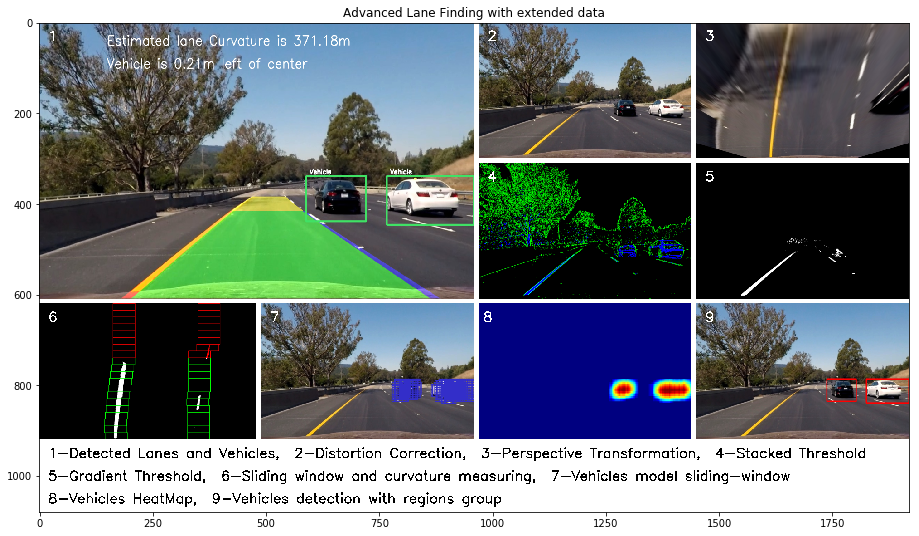

In [89]:
# Running the pipeline on a test image
# This cell will print the standard image output and the Extended display
%matplotlib inline

previous_boxes = []
image = mpimg.imread('/home/carnd/vehicle_detection/test_images/test6.jpg')

#mapped_lane = pipeline(image)
#plt.figure(figsize=(15, 8))
#plt.title('Advanced Lane Finding')
#plt.imshow(mapped_lane)

mapped_lane = pipeline(image, print_extended_view=True)
plt.figure(figsize=(20, 9))
plt.title('Advanced Lane Finding with extended data')
plt.imshow(mapped_lane)


In [92]:
# Test the pipeline for videos
from moviepy.editor import VideoFileClip
from IPython.display import HTML

previous_boxes = []
white_output = '/home/carnd/vehicle_detection/test_video/project_video_out.mp4'
clip1 = VideoFileClip("/home/carnd/vehicle_detection/test_video/project_video.mp4")
white_clip = clip1.fl_image(pipeline)#.subclip(25,31)
%time white_clip.write_videofile(white_output, audio=False)
clip1.reader.close()
clip1.audio.reader.close_proc()

[MoviePy] >>>> Building video /home/carnd/vehicle_detection/test_video/project_video_out.mp4
[MoviePy] Writing video /home/carnd/vehicle_detection/test_video/project_video_out.mp4


100%|█████████▉| 1260/1261 [24:19<00:01,  1.15s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /home/carnd/vehicle_detection/test_video/project_video_out.mp4 

CPU times: user 1h 20min 7s, sys: 4min 24s, total: 1h 24min 32s
Wall time: 24min 21s


In [144]:
# Test the pipeline for videos
from moviepy.editor import VideoFileClip
from IPython.display import HTML

white_output = 'C:\\data\\distortion\\project_video_extended.mp4'
clip1 = VideoFileClip("C:\\data\\distortion\\project_video.mp4")
white_clip = clip1.fl_image(pipeline)#.subclip(1,6)
%time white_clip.write_videofile(white_output, audio=False)
clip1.reader.close()
clip1.audio.reader.close_proc()

[MoviePy] >>>> Building video C:\Users\swillin\Documents\Private\courses\Driver\projects\advanced_lane_finding\test_videos\project_video_output_3.mp4
[MoviePy] Writing video C:\Users\swillin\Documents\Private\courses\Driver\projects\advanced_lane_finding\test_videos\project_video_output_3.mp4


100%|█████████▉| 1260/1261 [11:22<00:00,  1.86it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: C:\Users\swillin\Documents\Private\courses\Driver\projects\advanced_lane_finding\test_videos\project_video_output_3.mp4 

Wall time: 11min 24s


In [54]:
# Converting the output video to gif format for the github readme file
from moviepy.editor import VideoFileClip

clip = (VideoFileClip("C:\\Users\\swillin\\Documents\\Private\\courses\\Driver\\projects\\advanced_lane_finding\\test_videos\\project_video_extended.mp4")
        .resize(0.4).subclip(5,15))

clip.write_gif("project_video_extended.gif")


[MoviePy] Building file project_video_extended.gif with imageio


100%|█████████▉| 250/251 [01:00<00:00,  3.70it/s]
